In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

## compute the True distance matrix using UTM

In [2]:
MAT_PATH = "Matlab/ACT_data.mat"
anuData = sio.loadmat(MAT_PATH)

inds = anuData["valSet"]["valInd"][0][0]-1
inds = inds.reshape(-1)

utm = anuData["utm"]
cords = utm[inds]

In [3]:
true_dist_mat = np.zeros((8884,8884))
for i in range(8884):
    for j in range(i):
        true_dist_mat[i,j] = np.linalg.norm(cords[i]-cords[j])
        true_dist_mat[j,i] = true_dist_mat[i,j]

In [8]:
np.savez_compressed("true_corr_dist.npz", true_dist = true_dist_mat,)

## load and test

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace

### subroutines

In [2]:
# generate random sample from the 8884*8884 matrix
def random_xy(pnum):
    x = np.random.choice(8884, size=(pnum, 1), replace=True)
    y = np.random.choice(8884, size=(pnum, 1), replace=True)
    return np.concatenate([x,y], axis=-1)

In [3]:
def generate_plot_samples(true_dist, latent_dist, sample_points=None, radius=None):
    if radius is None:
        assert  isinstance(sample_points, np.ndarray)
    else:
        assert isinstance(radius, float)
        sample_points = np.argwhere(np.logical_and(t_dist_mat != 0., t_dist_mat < radius))

    true_sample =  true_dist[sample_points[:,0], sample_points[:,1]]
    latent_sample = latent_dist[sample_points[:,0], sample_points[:,1]]

    return true_sample, latent_sample

In [98]:
# presently save col rank only
# def distancestat(ss_dist_array, sg_dist_array, gg_dist_array, fname=None):
def distancestat(sg_dist_array, fname=None):
    # dist among: grd-sat, grd-sat_false, sat-sat_false, grd_false-sat
    col_correct_top1 = [] #correct top1; specific col (grd as ref)
    col_wrong_top1 = [] #wrong top1; specific col (grd as ref)
    row_correct_top1 = [] #correct top1; specific row (sat as ref)
    row_wrong_top1 = [] #wrong top1; specific row (sat as ref)
    for k in range(sg_dist_array.shape[0]):
        d_sat_grd = sg_dist_array[k, k]

        col_min_id = np.argmin(sg_dist_array[:, k])
        row_min_id = np.argmin(sg_dist_array[k, :])
        sg_dist_array[k,k] += 9999.

        # grd as ref
        if col_min_id == k:
            min_id = np.argmin(sg_dist_array[:, k])
            d_satF_grd = sg_dist_array[min_id, k]
            # d_sat_satF = ss_dist_array[min_id, k]
            col_correct_top1.append(
                # [float(k), float(min_id), d_sat_grd, d_satF_grd, d_sat_satF]
                [float(k), float(min_id), d_sat_grd, d_satF_grd]
            ) # idx, second_min_idx, d_sat_grd, d_satF_grd, d_sat_satF
        else:
            d_satF_grd = sg_dist_array[col_min_id, k]
            # d_sat_satF = ss_dist_array[col_min_id, k]
            col_wrong_top1.append(
                # [float(k), float(col_min_id), d_sat_grd, d_satF_grd, d_sat_satF]
                [float(k), float(col_min_id), d_sat_grd, d_satF_grd]
            ) # idx, min_idx, d_sat_grd, d_satF_grd, d_sat_satF

        # # sat as ref
        # if row_min_id == k:
        #     min_id = np.argmin(sg_dist_array[k, :])
        #     d_sat_grdF = sg_dist_array[k, min_id]
        #     d_grd_grdF = gg_dist_array[k, min_id]
        #     row_correct_top1.append(
        #         [float(k), float(min_id), d_sat_grd, d_sat_grdF, d_grd_grdF]
        #     ) # idx, second_min_idx, d_sat_grd, d_sat_grdF, d_grd_grdF
        # else:
        #     d_sat_grdF = sg_dist_array[k, row_min_id]
        #     d_grd_grdF = gg_dist_array[k, row_min_id]
        #     row_wrong_top1.append(
        #         [float(k), float(col_min_id), d_sat_grd, d_sat_grdF, d_grd_grdF]
        #     ) # idx, min_idx, d_sat_grd, d_sat_grdF, d_grd_grdF

    # fname = "./distance_dist.npz"
    np.savez_compressed(
        fname,
        col_correct_top1 = np.array(col_correct_top1),
        col_wrong_top1 = np.array(col_wrong_top1),
        # row_correct_top1 = np.array(row_correct_top1),
        # row_wrong_top1 = np.array(row_wrong_top1)
    )
    print(f"distance dist saved to {fname}", flush=True)

    return

### prepare data

In [4]:
# load true distances
with np.load("true_corr_dist.npz", allow_pickle=True) as data:
    t_dist_mat = data["true_dist"]

In [5]:
# data_cfg_dict = {
#     "train_set": "CVACT",
#     "train_set": "CVUSA",
#     "test_set": "CVACT",
#     "aug_flag": "strong_strong",
#     # "aug_flag": "strong_weak",
#     # "dist_type": "Satellite-Satellite",
#     "dist_type": "Satellite-Ground",
#     # "dist_type": "Ground-Ground",
#     "radius": 50.,
# }
# data_cfg = Namespace(**data_cfg_dict)
data_cfg_dict = {
    "aug_flag": "strong_strong",
    # "aug_flag": "strong_weak",
    # "dist_type": "Satellite-Satellite",
    "dist_type": "Satellite-Ground",
    # "dist_type": "Ground-Ground",
    "radius": 50.,
}
data_cfg = Namespace(**data_cfg_dict)

In [6]:
# load distances in latent space
dist_array_ACT_ACT = {
    "ss": None,
    "sg": None,
    "gg": None,
}

file_name = f"stats_corr_dist_SAFA_TR_testCVACT_trainCVACT_{data_cfg.aug_flag}.npz"
# file_name = f"stats_corr_dist_SAFA_TR_onedes_testCVACT_trainCVACT_{data_cfg.aug_flag}.npz"

with np.load(file_name, allow_pickle=True) as data:
    # for dt in ["ss", "sg", "gg"]:
    #     dist_array[dt] = data[f"{dt}_dist"]
    dist_array_ACT_ACT["sg"] = data["sg_dist"]

In [7]:
# load distances in latent space
dist_array_USA_ACT = {
    "ss": None,
    "sg": None,
    "gg": None,
}

file_name = f"stats_corr_dist_SAFA_TR_testCVACT_trainCVUSA_{data_cfg.aug_flag}.npz"
# file_name = f"stats_corr_dist_SAFA_TR_onedes_testCVACT_trainCVUSA_{data_cfg.aug_flag}.npz"

with np.load(file_name, allow_pickle=True) as data:
    dist_array_USA_ACT["sg"] = data["sg_dist"]

In [8]:
rand_points = random_xy(10000)

### compute and save the self- satellite-ground distance correlation

In [9]:
def plot_self_corr(correct, wrong, title, fname=None):
    fig, axs = plt.subplots(1, 2, figsize=(15,7))
    holder = axs[0].hist2d(correct[:,2], correct[:,3], bins=50, range=[[0., 2.], [0., 2.]], density=True)
    holder = axs[1].hist2d(wrong[:,2], wrong[:,3], bins=50, range=[[0., 2.], [0., 2.]], density=True)

    axs[0].set_xlim(0., 2.)    
    axs[0].set_ylim(0., 2.)
    axs[1].set_xlim(0., 2.)    
    axs[1].set_ylim(0., 2.)    

    axs[0].set_xlabel("ground truth distance", fontsize=16)
    axs[0].set_ylabel("false positive distance", fontsize=16)
    axs[1].set_xlabel("ground truth distance", fontsize=16)
    axs[1].set_ylabel("false positive distance", fontsize=16)

    axs[0].plot([0., 2.], [0., 2.], color="red")
    axs[1].plot([0., 2.], [0., 2.], color="red")

    fig.suptitle(title, fontsize=16, y=0.93)

    if fname is not None:
        fig.savefig(fname, bbox_inches='tight', dpi=200, facecolor="w")
        print(fname)
        plt.close(fig)

In [10]:
def plot_sim(sim_true_false_pos_correct, sim_true_false_pos_wrong, title, fname=None):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, gridspec_kw=dict(wspace=0.), figsize=(12,5))

    holder = axs[0].hist(sim_true_false_pos_correct, bins=50, density=True, label="correct samples")
    holder = axs[1].hist(sim_true_false_pos_wrong, bins=50, density=True, label="wrong samples")

    axs[0].set_xlabel("similarity", fontsize=16)
    axs[0].set_ylabel("density", fontsize=16)
    axs[1].set_xlabel("similarity", fontsize=16)

    axs[0].legend()
    axs[1].legend()

    fig.suptitle(title, fontsize=16, y=0.93)

    if fname is not None:
        fig.savefig(fname, bbox_inches='tight', dpi=200, facecolor="w")
        print(fname)
        plt.close(fig)

#### *** load data

In [14]:
# mark = f"test{data_cfg.test_set}_train{data_cfg.train_set}_{data_cfg.aug_flag}"
# f_name = f"sg_self_corr_dist_{mark}.npz"

In [13]:
#NOTE no need run if file already exist
# distancestat(dist_array["ss"], dist_array["sg"], dist_array["gg"], fname=f_name)
# distancestat(dist_array["sg"], fname=f_name)

distance dist saved to sg_self_corr_dist_testCVACT_trainCVUSA_strong_strong.npz


In [11]:
# load and anaylze
mark = f"testCVACT_trainCVACT_{data_cfg.aug_flag}"
f_name = f"sg_self_corr_dist_{mark}.npz"
with np.load(f_name, allow_pickle=True) as data:
    col_correct_top1_ACTACT = data["col_correct_top1"]
    col_wrong_top1_ACTACT = data["col_wrong_top1"]

In [12]:
mark = f"testCVACT_trainCVUSA_{data_cfg.aug_flag}"
f_name = f"sg_self_corr_dist_{mark}.npz"
with np.load(f_name, allow_pickle=True) as data:
    col_correct_top1_USAACT = data["col_correct_top1"]
    col_wrong_top1_USAACT = data["col_wrong_top1"]

#### *** select indices

In [40]:
# correct indices
correct_ids_ACTACT = col_correct_top1_ACTACT[:, 0].astype(int)
correct_ids_USAACT = col_correct_top1_USAACT[:, 0].astype(int)

In [41]:
# wrong indices
wrong_ids_ACTACT = col_wrong_top1_ACTACT[:, 0].astype(int)
wrong_ids_USAACT = col_wrong_top1_USAACT[:, 0].astype(int)

In [42]:
# in correcrt, hard indices
sim_threshold = 0.1

diff = col_correct_top1_ACTACT[:,3]-col_correct_top1_ACTACT[:,2]
correct_hard_ids_ACTACT = col_correct_top1_ACTACT[diff<=sim_threshold, 0].astype(int)

diff = col_correct_top1_USAACT[:,3]-col_correct_top1_USAACT[:,2]
correct_hard_ids_USAACT = col_correct_top1_USAACT[diff<=sim_threshold, 0].astype(int)

In [80]:
correct_hard_ids_USAACT.shape

(1663,)

#### *** distance dist & similarity dist

In [13]:
# sim_true_false_pos_correct = np.linalg.norm(col_correct_top1[:,2:3]-col_correct_top1[:,3:4], axis=-1, ord=1)
sim_true_false_pos_correct_ACTACT = col_correct_top1_ACTACT[:,3]-col_correct_top1_ACTACT[:,2]
sim_true_false_pos_wrong_ACTACT = col_wrong_top1_ACTACT[:,2]-col_wrong_top1_ACTACT[:,3]

In [14]:
sim_true_false_pos_correct_USAACT = col_correct_top1_USAACT[:,3]-col_correct_top1_USAACT[:,2]
sim_true_false_pos_wrong_USAACT = col_wrong_top1_USAACT[:,2]-col_wrong_top1_USAACT[:,3]

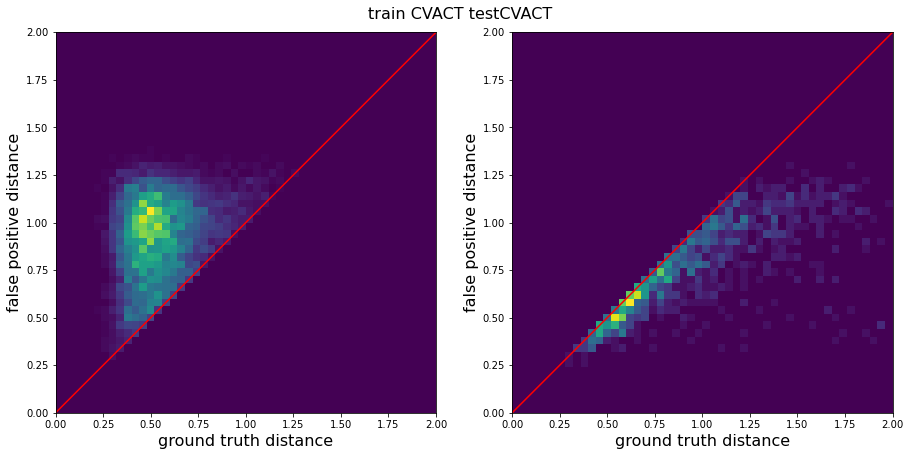

In [15]:
plot_self_corr(col_correct_top1_ACTACT, col_wrong_top1_ACTACT, title="train CVACT testCVACT", fname=None)

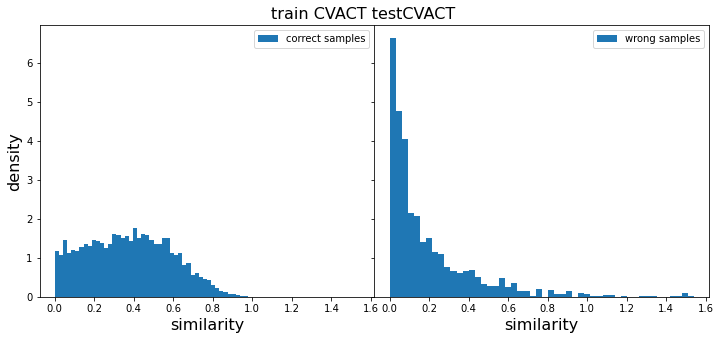

In [16]:
plot_sim(sim_true_false_pos_correct_ACTACT, sim_true_false_pos_wrong_ACTACT, title="train CVACT testCVACT", fname=None)

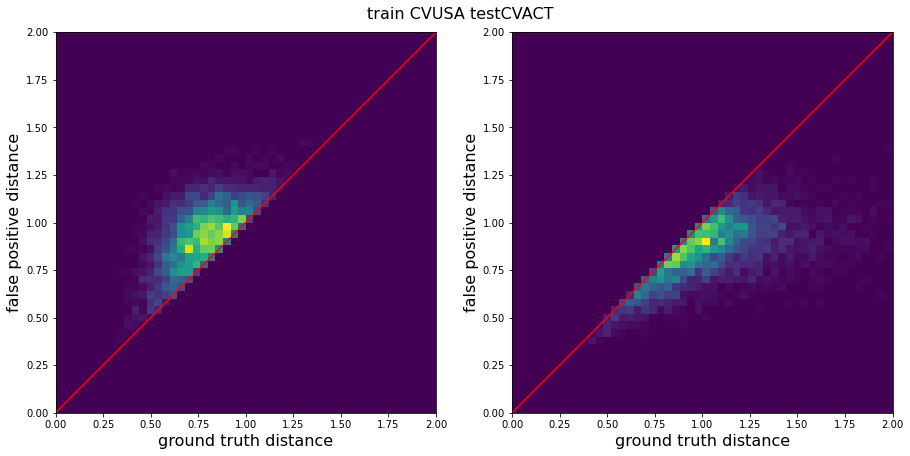

In [17]:
plot_self_corr(col_correct_top1_USAACT, col_wrong_top1_USAACT, title="train CVUSA testCVACT", fname=None)

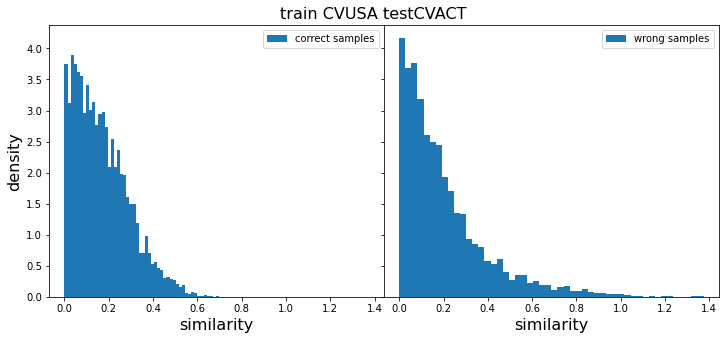

In [18]:
plot_sim(sim_true_false_pos_correct_USAACT, sim_true_false_pos_wrong_USAACT, title="train CVUSA testCVACT", fname=None)

### compute & plot

In [19]:
def plot_corr_dist(t_sampe, sample, cfg, fname=None):
    if cfg.radius is not None:
        suffix = f"<{cfg.radius}m"
    else:
        suffix = "random"
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))

    tmax = np.max(t_sampe)
    smax = np.max(sample)
    holder = ax.hist2d(t_sampe, sample, bins=50, range=[[0., tmax], [0., smax]], density=True)

    ax.set_xlim(left=0.)
    ax.set_ylim(bottom=0.)

    ax.set_xlabel("Geo distance (m)",fontsize=16)
    ax.set_ylabel("Latent distance",fontsize=16)

    mark = f"{cfg.dist_type} {cfg.train_set}_{cfg.test_set}"
    ax.set_title(f"{mark} Dist. Corr. ({suffix})", fontsize=14)

    if fname is not None:
        fname = f"corr_dsit_{mark}_{suffix}.png"
        fig.savefig(fname, bbox_inches='tight', dpi=200, facecolor="w")
        print(fname)
        plt.close(fig)

In [20]:
def plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, cfg, fname=None):
    if cfg.radius is not None:
        suffix = f"<{cfg.radius}m"
    else:
        suffix = "random"
    
    fig, axs = plt.subplots(1, 2, figsize=(15,7))

    tmax_ACTACT = np.max(t_sampe_ACTACT)
    smax_ACTACT = np.max(sample_ACTACT)
    holder = axs[0].hist2d(t_sampe_ACTACT, sample_ACTACT, bins=50, range=[[0., tmax_ACTACT], [0., smax_ACTACT]], density=True)

    tmax_USAACT = np.max(t_sampe_USAACT)
    smax_USAACT = np.max(sample_USAACT)
    holder = axs[1].hist2d(t_sampe_USAACT, sample_USAACT, bins=50, range=[[0., tmax_USAACT], [0., smax_USAACT]], density=True)

    axs[0].set_xlim(left=0.)
    axs[0].set_ylim(bottom=0.)
    axs[0].set_xlabel("Geo distance (m)",fontsize=16)
    axs[0].set_ylabel("Latent distance",fontsize=16)

    axs[1].set_xlim(left=0.)
    axs[1].set_ylim(bottom=0.)
    axs[1].set_xlabel("Geo distance (m)",fontsize=16)
    axs[1].set_ylabel("Latent distance",fontsize=16)

    axs[0].set_title(f"{cfg.dist_type} CVACT_CVACT Dist. Corr. ({suffix})", fontsize=14)
    axs[1].set_title(f"{cfg.dist_type} CVUSA_CVACT Dist. Corr. ({suffix})", fontsize=14)

    if fname is not None:
        fname = f"corr_dsit_{suffix}.png"
        fig.savefig(fname, bbox_inches='tight', dpi=200, facecolor="w")
        print(fname)
        plt.close(fig)

In [29]:
# presently consider sg only
# t_sampe, sample = generate_plot_samples(t_dist_mat, dist_array["sg"], sample_points=rand_points, radius=data_cfg.radius)
# t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_ACT_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)
# t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_USA_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)

In [30]:
# plot_corr_dist(t_sampe, sample, data_cfg, fname=None)
# plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [23]:

data_cfg.radius = None
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_ACT_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_USA_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)

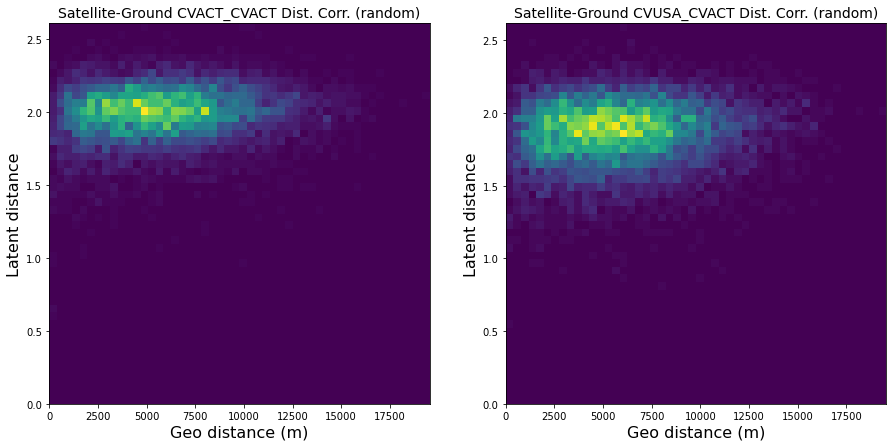

In [24]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [27]:
data_cfg.radius = 100.
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_ACT_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_USA_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)

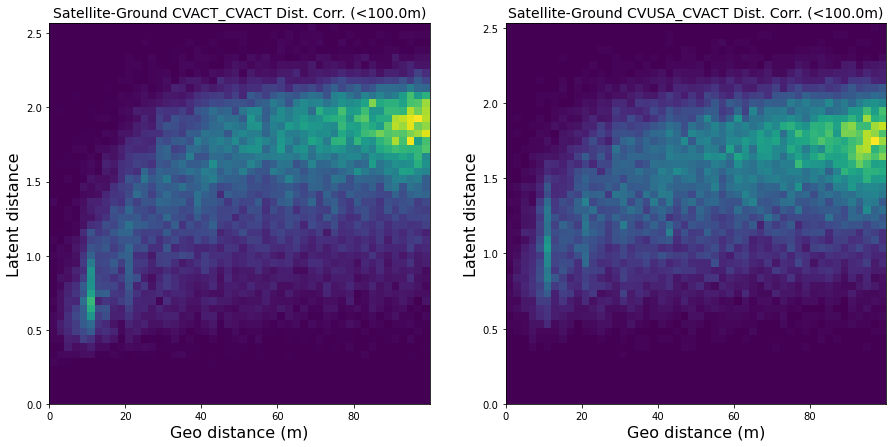

In [28]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [93]:
data_cfg.radius = 500.
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_ACT_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_USA_ACT["sg"], sample_points=rand_points, radius=data_cfg.radius)

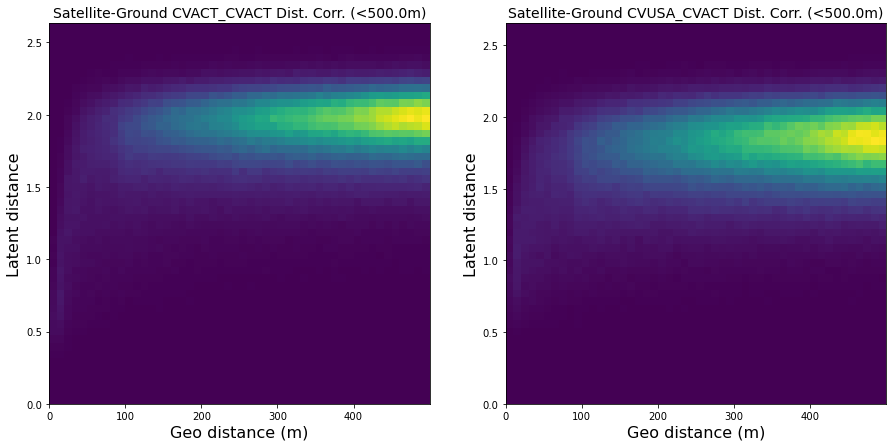

In [94]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

#### *** statistics on selected samples

In [36]:
def random_xy_gen(pnum, xlim=None, ylim=None):
    if xlim is None:
        xlim = 8884
    if ylim is None:
        ylim = 8884
    x = np.random.choice(xlim, size=(pnum, 1), replace=True)
    y = np.random.choice(ylim, size=(pnum, 1), replace=True)
    return np.concatenate([x,y], axis=-1)

In [37]:
def generate_plot_samples(true_dist, latent_dist, sample_points=None, radius=None):
    if radius is None:
        assert  isinstance(sample_points, np.ndarray)
    else:
        assert isinstance(radius, float)
        sample_points = np.argwhere(np.logical_and(true_dist != 0., true_dist < radius))

    true_sample =  true_dist[sample_points[:,0], sample_points[:,1]]
    latent_sample = latent_dist[sample_points[:,0], sample_points[:,1]]

    return true_sample, latent_sample

*on selected correct ids*

In [57]:
# 
t_dist_mat_select_correct_ACTACT = t_dist_mat[correct_ids_ACTACT]
dist_array_select_correct_ACTACT = dist_array_ACT_ACT["sg"][correct_ids_ACTACT]

t_dist_mat_select_correct_USAACT = t_dist_mat[correct_ids_USAACT]
dist_array_select_correct_USAACT = dist_array_USA_ACT["sg"][correct_ids_USAACT]

In [58]:
rand_points_correct_ACTACT = random_xy_gen(10000, xlim=len(correct_ids_ACTACT))
rand_points_correct_USAACT = random_xy_gen(10000, xlim=len(correct_ids_USAACT))

In [59]:
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_correct_ACTACT, dist_array_select_correct_ACTACT, sample_points=rand_points_correct_ACTACT, radius=None)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_correct_USAACT, dist_array_select_correct_USAACT, sample_points=rand_points_correct_USAACT, radius=None)

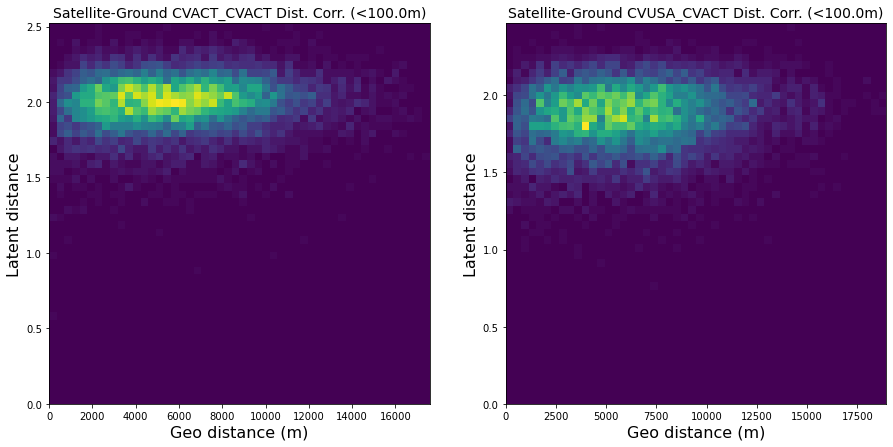

In [60]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [61]:
tmp_radius = 100.

t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_correct_ACTACT, dist_array_select_correct_ACTACT, sample_points=None, radius=tmp_radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_correct_USAACT, dist_array_select_correct_USAACT, sample_points=None, radius=tmp_radius)

In [63]:
t_sampe_ACTACT.shape

(36290,)

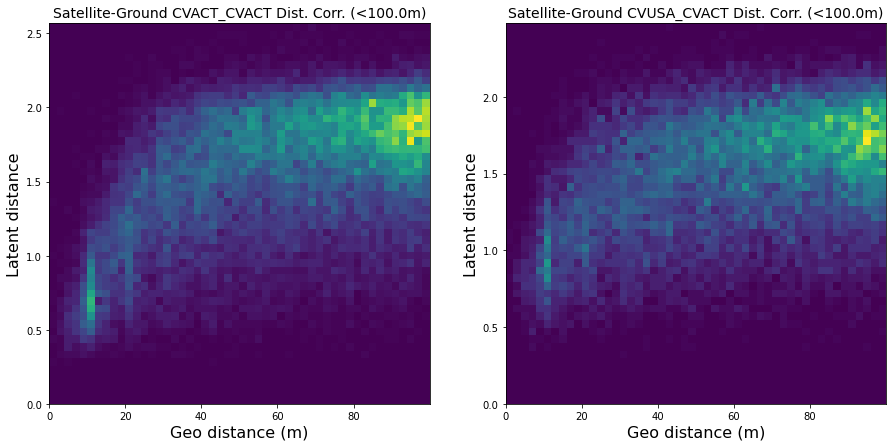

In [62]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

*on selected wrong ids*

In [64]:
# 
t_dist_mat_select_wrong_ACTACT = t_dist_mat[wrong_ids_ACTACT]
dist_array_select_wrong_ACTACT = dist_array_ACT_ACT["sg"][wrong_ids_ACTACT]

t_dist_mat_select_wrong_USAACT = t_dist_mat[wrong_ids_USAACT]
dist_array_select_wrong_USAACT = dist_array_USA_ACT["sg"][wrong_ids_USAACT]

In [65]:
rand_points_wrong_ACTACT = random_xy_gen(10000, xlim=len(wrong_ids_ACTACT))
rand_points_wrong_USAACT = random_xy_gen(10000, xlim=len(wrong_ids_USAACT))

In [66]:
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_wrong_ACTACT, dist_array_select_wrong_ACTACT, sample_points=rand_points_wrong_ACTACT, radius=None)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_wrong_USAACT, dist_array_select_wrong_USAACT, sample_points=rand_points_wrong_USAACT, radius=None)

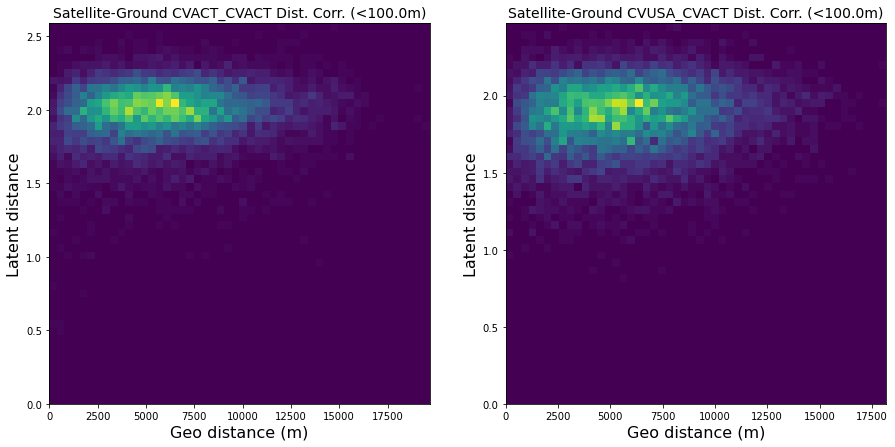

In [67]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [68]:
tmp_radius = 100.

t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_wrong_ACTACT, dist_array_select_wrong_ACTACT, sample_points=None, radius=tmp_radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_wrong_USAACT, dist_array_select_wrong_USAACT, sample_points=None, radius=tmp_radius)

In [70]:
t_sampe_ACTACT.shape

(7528,)

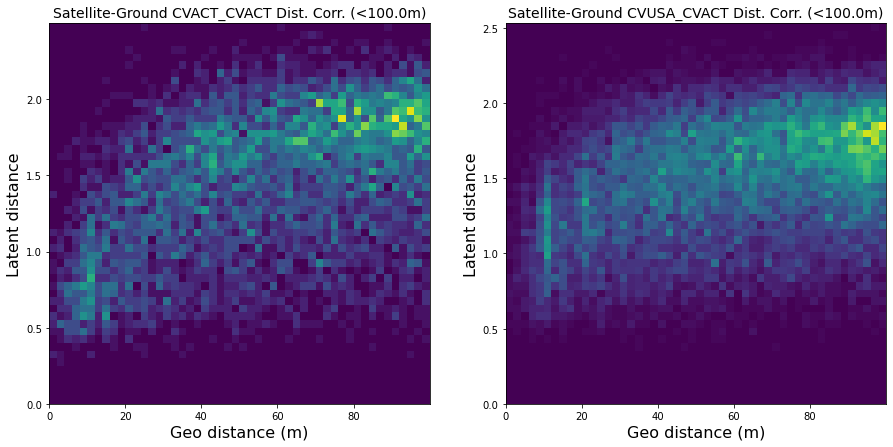

In [69]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

*on selected correct hard ids*

In [47]:
# 
t_dist_mat_select_correct_hard_ACTACT = t_dist_mat[correct_hard_ids_ACTACT]
dist_array_select_correct_hard_ACTACT = dist_array_ACT_ACT["sg"][correct_hard_ids_ACTACT]

t_dist_mat_select_correct_hard_USAACT = t_dist_mat[correct_hard_ids_USAACT]
dist_array_select_correct_hard_USAACT = dist_array_USA_ACT["sg"][correct_hard_ids_USAACT]

In [51]:
rand_points_correct_hard_ACTACT = random_xy_gen(10000, xlim=len(correct_hard_ids_ACTACT))
rand_points_correct_hard_USAACT = random_xy_gen(10000, xlim=len(correct_hard_ids_USAACT))

In [52]:
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_correct_hard_ACTACT, dist_array_select_correct_hard_ACTACT, sample_points=rand_points_correct_hard_ACTACT, radius=None)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_correct_hard_USAACT, dist_array_select_correct_hard_USAACT, sample_points=rand_points_correct_hard_USAACT, radius=None)

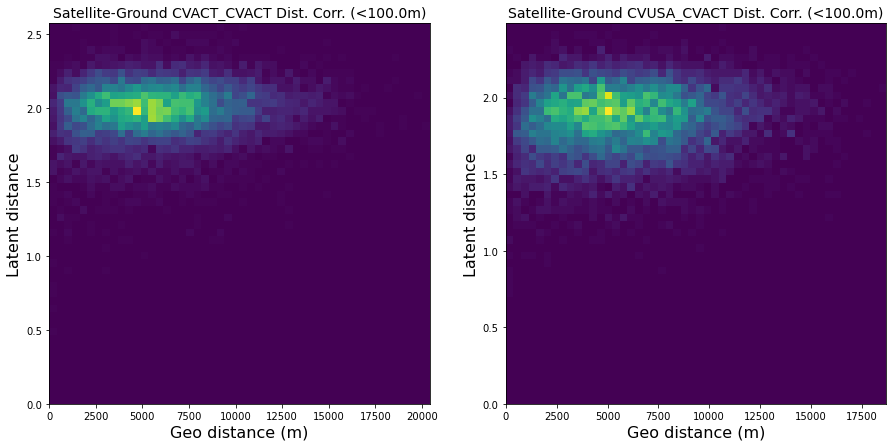

In [53]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [55]:
tmp_radius = 100.

t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_correct_hard_ACTACT, dist_array_select_correct_hard_ACTACT, sample_points=None, radius=tmp_radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_correct_hard_USAACT, dist_array_select_correct_hard_USAACT, sample_points=None, radius=tmp_radius)


In [56]:
t_sampe_ACTACT.shape

(5469,)

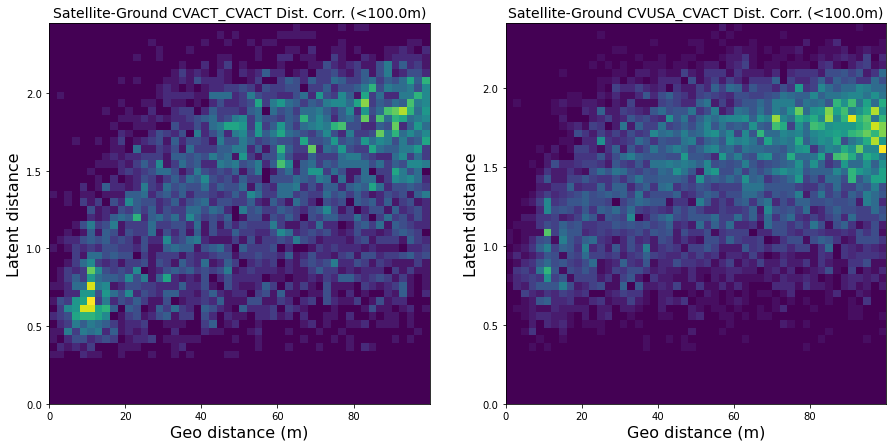

In [49]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

#### *** random select test

In [81]:
random_select_ids_ACTACT = np.sort(np.random.choice(8884, size=(1000,), replace=False))
random_select_ids_USAACT = np.sort(np.random.choice(8884, size=(1600,), replace=False))

In [82]:
t_dist_mat_select_random_ACTACT = t_dist_mat[random_select_ids_ACTACT]
dist_array_select_random_ACTACT = dist_array_ACT_ACT["sg"][random_select_ids_ACTACT]

t_dist_mat_select_random_USAACT = t_dist_mat[random_select_ids_USAACT]
dist_array_select_random_USAACT = dist_array_USA_ACT["sg"][random_select_ids_USAACT]

In [83]:
tmp_radius = 100.

t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(
    t_dist_mat_select_random_ACTACT, dist_array_select_random_ACTACT, sample_points=None, radius=tmp_radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(
    t_dist_mat_select_random_USAACT, dist_array_select_random_USAACT, sample_points=None, radius=tmp_radius)

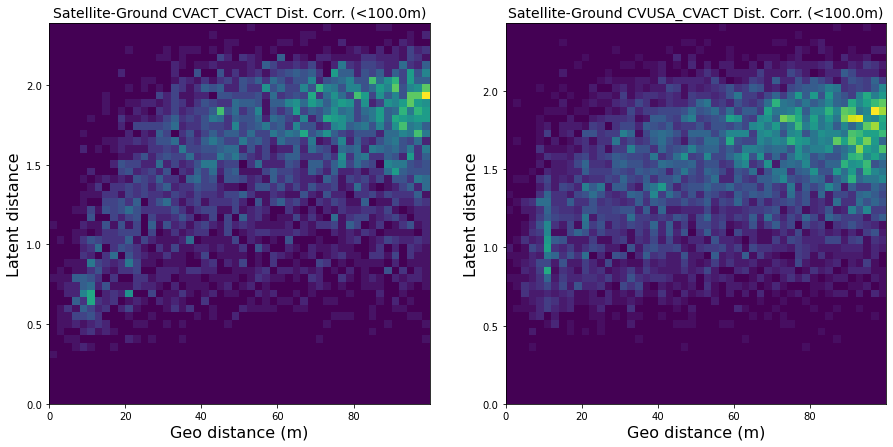

In [84]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

## One des

In [85]:
data_cfg_dict = {
    "aug_flag": "strong_weak",
    # "dist_type": "Satellite-Satellite",
    "dist_type": "Satellite-Ground",
    # "dist_type": "Ground-Ground",
    "radius": 50.,
}
data_cfg = Namespace(**data_cfg_dict)

In [86]:
dist_array_one_ACT_ACT = {
    "ss": None,
    "sg": None,
    "gg": None,
}

file_name = f"stats_corr_dist_SAFA_TR_onedes_testCVACT_trainCVACT_{data_cfg.aug_flag}.npz"

with np.load(file_name, allow_pickle=True) as data:
    dist_array_one_ACT_ACT["sg"] = data["sg_dist"]

In [87]:
dist_array_one_USA_ACT = {
    "ss": None,
    "sg": None,
    "gg": None,
}

file_name = f"stats_corr_dist_SAFA_TR_onedes_testCVACT_trainCVUSA_{data_cfg.aug_flag}.npz"

with np.load(file_name, allow_pickle=True) as data:
    dist_array_one_USA_ACT["sg"] = data["sg_dist"]

In [88]:
rand_points_one = random_xy(10000)

In [89]:
data_cfg.radius = None
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_one_ACT_ACT["sg"], sample_points=rand_points_one, radius=data_cfg.radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_one_USA_ACT["sg"], sample_points=rand_points_one, radius=data_cfg.radius)

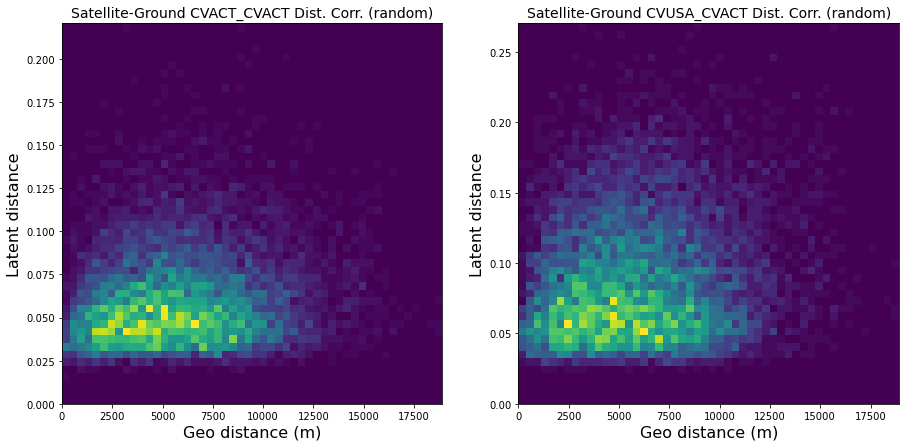

In [90]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

In [91]:
data_cfg.radius = 100.
t_sampe_ACTACT, sample_ACTACT = generate_plot_samples(t_dist_mat, dist_array_one_ACT_ACT["sg"], sample_points=rand_points_one, radius=data_cfg.radius)
t_sampe_USAACT, sample_USAACT = generate_plot_samples(t_dist_mat, dist_array_one_USA_ACT["sg"], sample_points=rand_points_one, radius=data_cfg.radius)

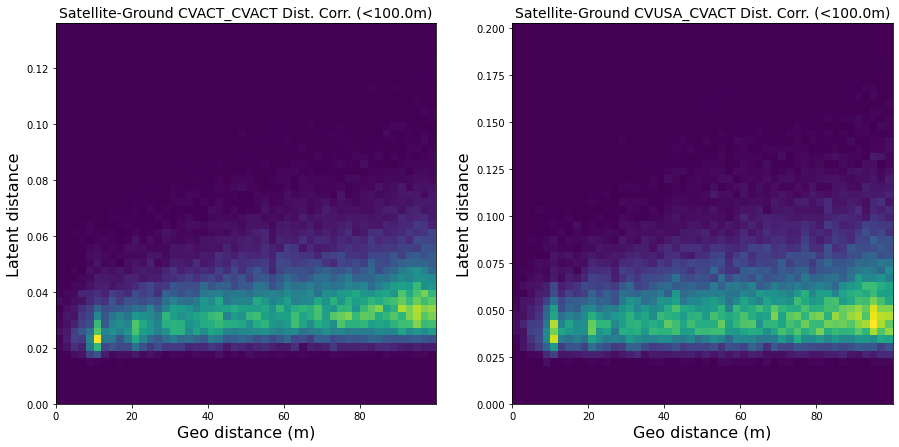

In [92]:
plot_corr_dist_double(t_sampe_ACTACT, sample_ACTACT, t_sampe_USAACT, sample_USAACT, data_cfg, fname=None)

#### onedes sim dist

In [100]:
# mark = f"testCVACT_trainCVUSA_{data_cfg.aug_flag}"
# f_name = f"sg_self_corr_dist_onedes_{mark}.npz"

In [101]:
# distancestat(dist_array_one_USA_ACT["sg"], fname=f_name)

distance dist saved to sg_self_corr_dist_onedes_testCVACT_trainCVUSA_strong_weak.npz


In [102]:
# load and anaylze
mark = f"testCVACT_trainCVACT_{data_cfg.aug_flag}"
f_name = f"sg_self_corr_dist_onedes_{mark}.npz"
with np.load(f_name, allow_pickle=True) as data:
    col_correct_top1_onedes_ACTACT = data["col_correct_top1"]
    col_wrong_top1_onedes_ACTACT = data["col_wrong_top1"]

In [103]:
mark = f"testCVACT_trainCVUSA_{data_cfg.aug_flag}"
f_name = f"sg_self_corr_dist_onedes_{mark}.npz"
with np.load(f_name, allow_pickle=True) as data:
    col_correct_top1_onedes_USAACT = data["col_correct_top1"]
    col_wrong_top1_onedes_USAACT = data["col_wrong_top1"]

In [104]:
sim_true_false_pos_correct_onedes_ACTACT = col_correct_top1_onedes_ACTACT[:,3]-col_correct_top1_onedes_ACTACT[:,2]
sim_true_false_pos_wrong_onedes_ACTACT = col_wrong_top1_onedes_ACTACT[:,2]-col_wrong_top1_onedes_ACTACT[:,3]

In [105]:
sim_true_false_pos_correct_onedes_USAACT = col_correct_top1_onedes_USAACT[:,3]-col_correct_top1_onedes_USAACT[:,2]
sim_true_false_pos_wrong_onedes_USAACT = col_wrong_top1_onedes_USAACT[:,2]-col_wrong_top1_onedes_USAACT[:,3]

In [112]:
def plot_self_corr2(correct, wrong, title, fname=None):
    fig, axs = plt.subplots(1, 2, figsize=(15,7))
    holder = axs[0].hist2d(correct[:,2], correct[:,3], bins=50, range=[[0., 0.05], [0., 0.05]], density=True)
    holder = axs[1].hist2d(wrong[:,2], wrong[:,3], bins=50, range=[[0., 0.05], [0., 0.05]], density=True)

    axs[0].set_xlim(0., 0.05)    
    axs[0].set_ylim(0., 0.05)
    axs[1].set_xlim(0., 0.05)    
    axs[1].set_ylim(0., 0.05)    

    axs[0].set_xlabel("ground truth distance", fontsize=16)
    axs[0].set_ylabel("false positive distance", fontsize=16)
    axs[1].set_xlabel("ground truth distance", fontsize=16)
    axs[1].set_ylabel("false positive distance", fontsize=16)

    axs[0].plot([0., 0.05], [0., 0.05], color="red")
    axs[1].plot([0., 0.05], [0., 0.05], color="red")

    fig.suptitle(title, fontsize=16, y=0.93)

    if fname is not None:
        fig.savefig(fname, bbox_inches='tight', dpi=200, facecolor="w")
        print(fname)
        plt.close(fig)

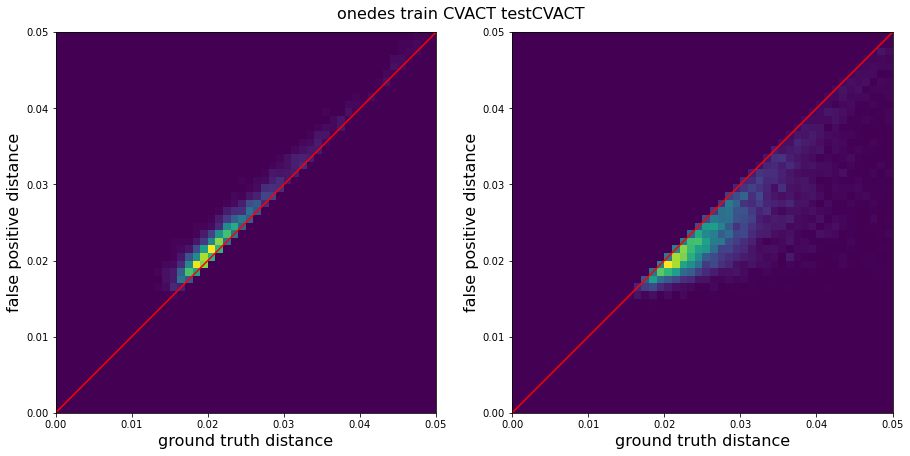

In [113]:
plot_self_corr2(col_correct_top1_onedes_ACTACT, col_wrong_top1_onedes_ACTACT, title="onedes train CVACT testCVACT", fname=None)

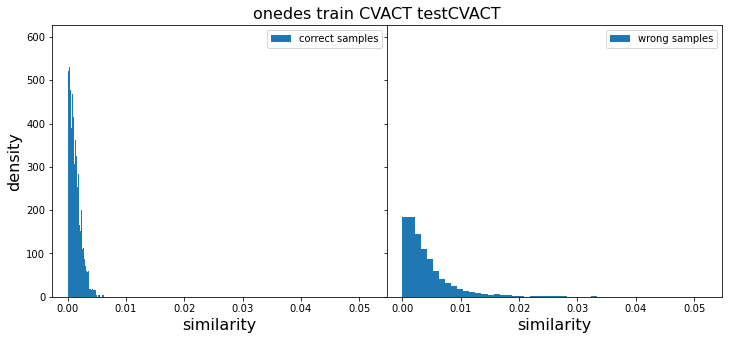

In [107]:
plot_sim(sim_true_false_pos_correct_onedes_ACTACT, sim_true_false_pos_wrong_onedes_ACTACT, title="onedes train CVACT testCVACT", fname=None)

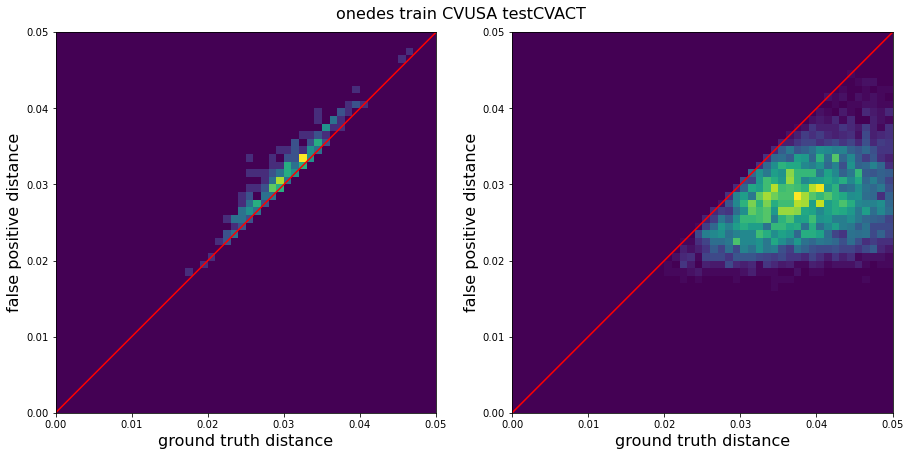

In [115]:
plot_self_corr2(col_correct_top1_onedes_USAACT, col_wrong_top1_onedes_USAACT, title="onedes train CVUSA testCVACT", fname=None)

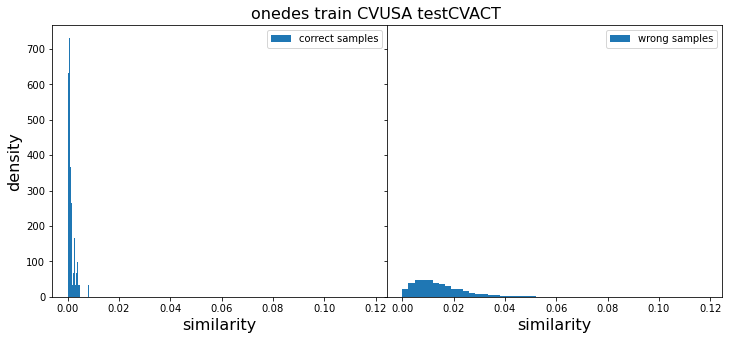

In [109]:
plot_sim(sim_true_false_pos_correct_onedes_USAACT, sim_true_false_pos_wrong_onedes_USAACT, title="onedes train CVUSA testCVACT", fname=None)

### wrong pred and their geo distance